In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from IPython.display import Image
import pandas as pd
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy as sp
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn import datasets
from sklearn.metrics import mean_absolute_error

/Users/yoko/.anyenv/envs/pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [77]:
df_train = pd.read_csv('input/train.csv', index_col='datetime', parse_dates=[0])
df_train['month'] = df_train.index.month
df_train['day'] = df_train.index.day
df_train['weekday'] = df_train.index.weekday_name
df_train['week'] = df_train.index.week
df_train['year'] = df_train.index.year

syukujitsu = pd.read_csv('input/syukujitsu.csv')
syukujitsu = pd.to_datetime(syukujitsu['date'])
df_train['holiday'] = df_train['weekday'].isin(['Saturday', 'Sunday'])
df_train['holiday'] |= df_train.index.isin(syukujitsu)

df_train['weekday'] = df_train.index.weekday

def split_month_3(day):
    if day <= 10:
        return 0
    elif day > 10 and day <= 20:
        return 1
    else:
        return 2
        
df_train['month_split'] = df_train['day'].apply(split_month_3)
        
df_train['time_from_first'] = df_train[['year', 'month', 'day']].apply(
    lambda x: (x['year'] -2010) * 365 + x['month'] * 30 + x['day'], axis=1)
#df_train['time_from_first'] = (df_train['time_from_first'] - df_train['time_from_first'].mean()) / df_train['time_from_first'].std()
time_max = df_train['time_from_first'].max()
df_train['time_from_first'] /= time_max
df_train.drop('year', axis=1, inplace=True)

In [78]:
df_test = pd.read_csv('input/test.csv', index_col='datetime', parse_dates=[0])
df_test['month'] = df_test.index.month
df_test['day'] = df_test.index.day
df_test['weekday'] = df_test.index.weekday_name
df_test['week'] = df_test.index.week
df_test['year'] = df_test.index.year

syukujitsu = pd.read_csv('input/syukujitsu.csv')
syukujitsu = pd.to_datetime(syukujitsu['date'])
df_test['holiday'] = df_test['weekday'].isin(['Saturday', 'Sunday'])
df_test['holiday'] |= df_test.index.isin(syukujitsu)

df_test['weekday'] = df_test.index.weekday

df_test['month_split'] = df_test['day'].apply(split_month_3)
df_test['time_from_first'] = df_test[['year', 'month', 'day']].apply(
    lambda x: (x['year'] -2010) * 365 + x['month'] * 30 + x['day'], axis=1)
df_test['time_from_first'] /= time_max
df_test.drop('year', axis=1, inplace=True)

In [79]:
df_train = df_train[df_train['close'] == 0]
df_train.drop('close', axis=1, inplace=True)

df_test_close = df_test[df_test['close'] == 1]
df_test = df_test[df_test['close'] == 0]
df_test.drop('close', axis=1, inplace=True)

In [80]:
y_train = df_train['y']
X_train = df_train.copy()
X_train.drop('y', axis=1, inplace=True)
X_test = df_test.copy()

In [5]:
xgb_model = xgb.XGBRegressor()
xgb_model.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

In [69]:
xgb_model = xgb.XGBRegressor()

params = {
    "learning_rate": [1e-1, 5e-2, 1e-2, 5e-2],
    "max_depth": sp.stats.randint(4, 10),
    "subsample": sp.stats.uniform(0.5, 0.5),
    "colsample_bytree": sp.stats.uniform(0.5, 0.5),
    "min_child_weight": sp.stats.randint(4, 10),
    "n_estimators": sp.stats.randint(20, 100),
}

rs = RandomizedSearchCV(xgb_model,
                        params,
                        cv=5,
                        n_iter=1000,
                        scoring="neg_mean_absolute_error",
                        n_jobs=1,
                        verbose=1)

rs.fit(X_train, y_train)
#model.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:  9.1min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=1000, n_jobs=1,
          param_distributions={'learning_rate': [0.1, 0.05, 0.01, 0.05], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x114779d68>, 'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1147798d0>, 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1147792b0>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1147795c0>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11477

In [70]:
rs.best_params_

{'colsample_bytree': 0.69790884172398893,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 6,
 'n_estimators': 66,
 'subsample': 0.54310533113731518}

In [71]:
model = xgb.XGBRegressor(**rs.best_params_)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.69790884172398893, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=6, missing=None,
       n_estimators=66, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.54310533113731518)

In [72]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [73]:
mean_absolute_error(pred_train, y_train)

3.5792384303984095

In [99]:
df_test['y'] = pred_test
df_test_close['y'] = 0
df_pred = pd.concat([df_test['y'], df_test_close['y']]).sort_index()

In [98]:
df_sample = pd.read_csv('input/sample_submit.csv', header=None)
df_sample.iloc[:, 1] = df_pred.values
df_sample.to_csv('submit/submit.csv', header=None, index=False)

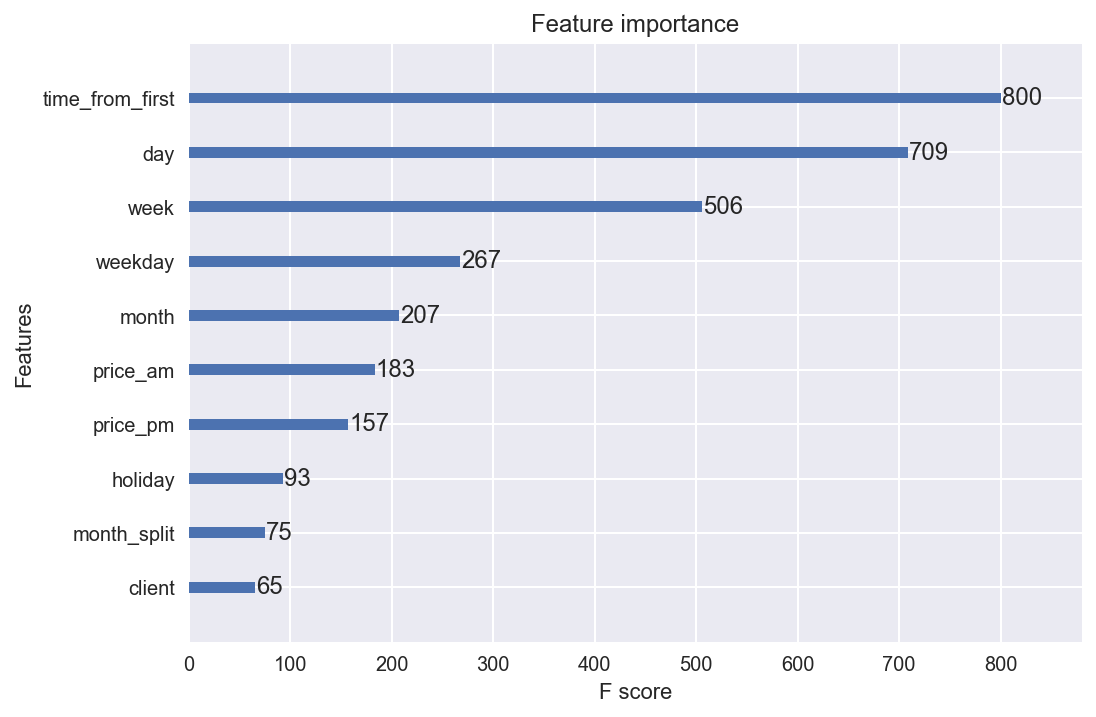

In [100]:
xgb.plot_importance(model)

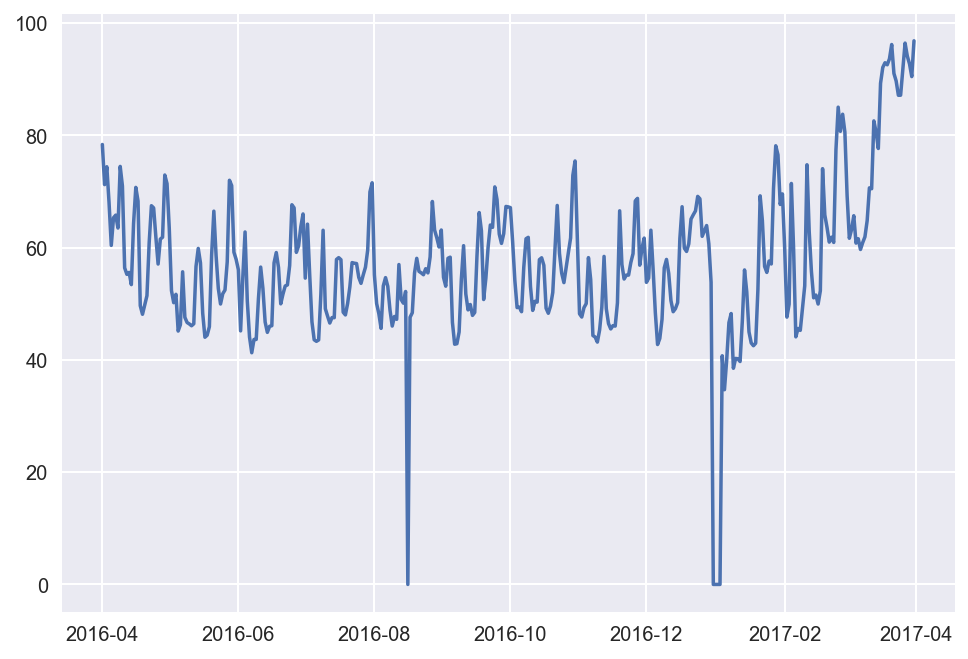

In [101]:
plt.plot(df_pred)

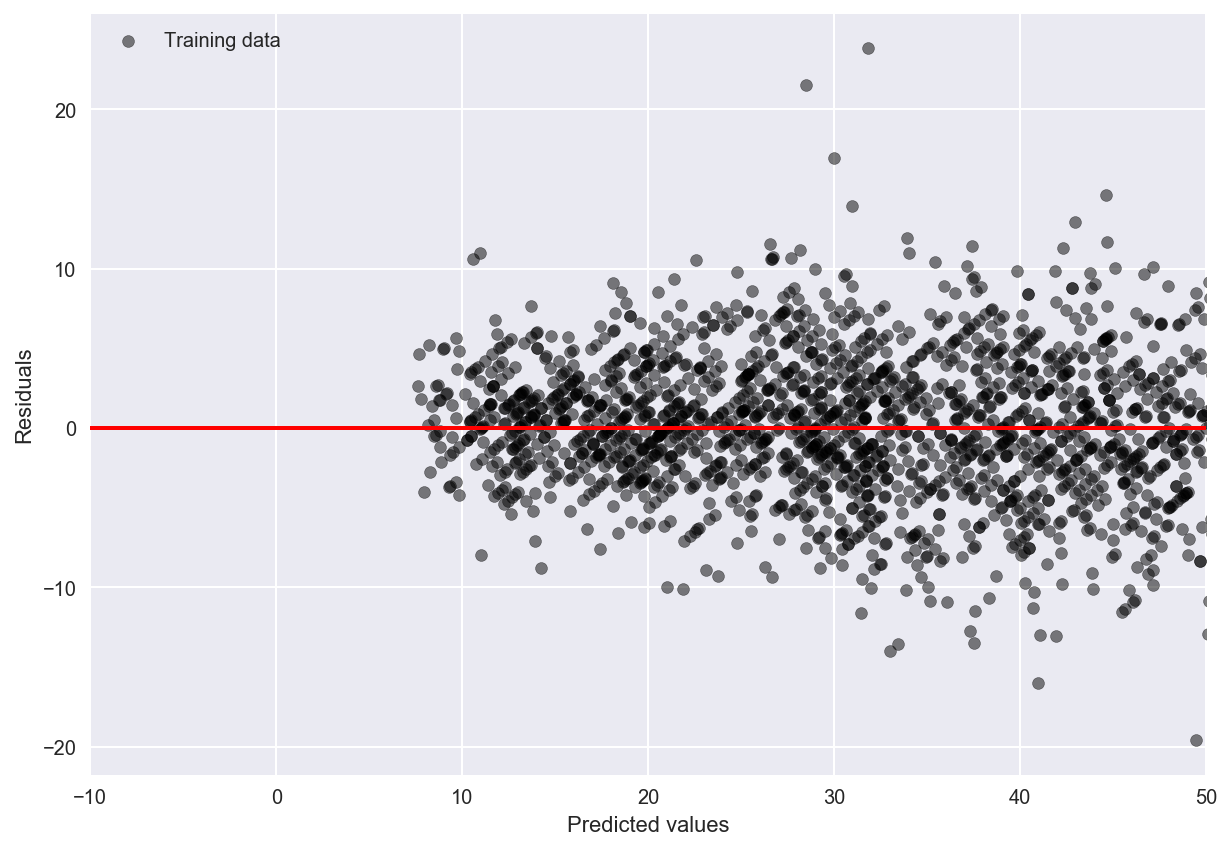

In [103]:
y_train_pred = model.predict(X_train)
plt.figure(figsize = (10, 7))
plt.scatter(y_train_pred, y_train_pred - y_train, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
#plt.scatter(y_test_pred, y_test_pred - y_test, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, lw = 2, color = 'red')
plt.xlim([-10, 50])
plt.show()